Chaining: Chaining Lens Light To Mass
=====================================

In this script, we chain two searches to fit `Imaging` with a strong lens model where:

 - The lens galaxy's light is a bulge+disk `EllSersic` and `EllSersic`.
 - The lens galaxy's stellar mass distribution is a bulge+disk tied to the light model above.
 - The lens galaxy's dark matter mass distribution is a `SphNFW`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

The two searches break down as follows:

 1) Models the lens galaxy's light using an `EllSersic` bulge and `EllSersic` disk. The source is
 present in the image, but modeling it is omitted.

 2) Models the lens galaxy's mass using a stellar mass distriubtion which is initialized using the bulge and disk light
 models inferred by search 1, alongside a dark matter profile. The source is again modeled using an `EllSersic`

__Why Chain?__

For many strong lenses the lens galaxy's light is distinct from the source galaxy's light, and it is therefore a valid
approach to first subtract the lens's light and then focus on fitting the lens mass model and source's light. This
provides the following benefits:

 - The non-linear parameter space defined by a bulge-disk (N=11), stellar and dark mass (N=5) and parametric source (N=7)
 has N=27 dimensions. By splitting the model-fit into two searches, we fit parameter spaces of dimensions N=11 and then
 N=27, with many priors initialized. These are more efficient to sample and less like to infer a local maxima or
 unphysical solution.

 - The lens galaxy's light traces its mass, so we can use the lens light model inferred in search 1 to initialize
 sampling of the stellar mass model in search 2.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

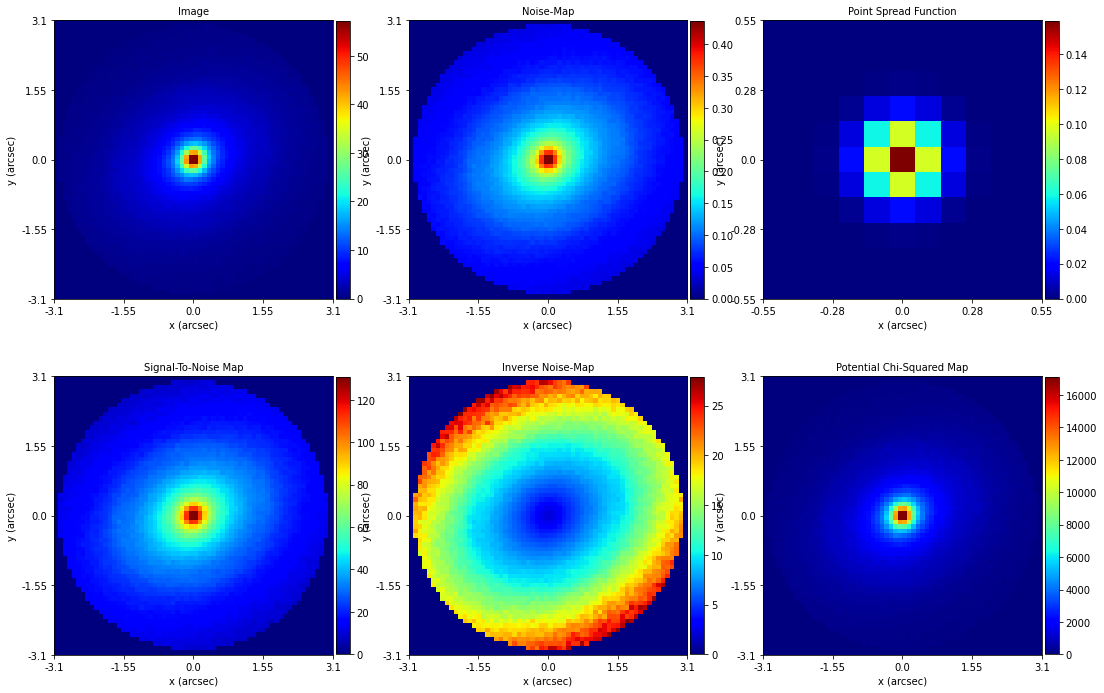

In [2]:
dataset_name = "light_sersic_exp__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "chaining", "lens_light_to_light_dark_mass")

__Model (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's light is a parametric `EllSersic` bulge and `EllSersic` disk, the centres of 
 which are aligned [11 parameters].
 - The lens galaxy's mass and source galaxy are omitted.

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=11.

In [4]:
bulge = af.Model(al.lp.EllSersic)
disk = af.Model(al.lp.EllSersic)

bulge.centre = disk.centre

lens = af.Model(al.Galaxy, redshift=0.5, bulge=bulge, disk=disk)

model = af.Collection(galaxies=af.Collection(lens=lens))


__Search + Analysis + Model-Fit (Search 1)__

We use the results of search 1 to create the lens model fitted in search 2, where:

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.

In [5]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]__lens_light", nlive=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.57it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -553655.252 <    inf | logz: -553659.916 +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's light and stellar mass is a parametric `EllSersic` bulge and `EllSersic` 
 disk [8 parameters: priors initialized from search 1].
 - The lens galaxy's dark matter mass distribution is a `EllNFW` whose centre is aligned with the 
 `EllSersic` bulge and stellar mass model above [5 parameters].
 - The lens mass model also includes an `ExternalShear` [2 parameters].
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=22.

We use the `take_attributes` method to pass the priors of the bulge+disk. The reason we use this method is because
the bulge+disk above use a `LightProfile` (e.g. via `al.lp`), whereas the model below gives a `LightAndMassProfile` 
(e.g. via `al.lmp`). 

The `take_attributes` method is used when we pass parameters from two different models. In the example below it finds
all parameters in the `EllSersic` and `EllSersic` light models that share the same names
as parameters in the ``EllSersic` and `EllSersic` light and mass models and passes their priors 
(in this case, the `centre`, `elliptical_comps`, `intensity`, `effective_radius` and `sersic_index`).

In [6]:
bulge = af.Model(al.lmp.EllSersic)
bulge.take_attributes(source=result_1.model)

disk = af.Model(al.lmp.EllSersic)
disk.take_attributes(source=result_1.model)

lens = af.Model(
    al.Galaxy, redshift=0.5, bulge=bulge, disk=disk, dark=af.Model(al.mp.EllNFW)
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens))

__Search + Analysis + Model-Fit (Search 2)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the `model.info` file of the search 2 model-fit to ensure the priors were passed correctly, as 
well as the checkout the results to ensure an accurate power-law mass model is inferred.

In [7]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[2]__light_dark_mass", nlive=50
)


analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 163.92it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -554843.376 <    inf | logz: -554848.041 +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Wrap Up__

In this example, we passed a bulge + disk lens light model to a decomposed stellar + dark matter mass model. Thus, we
use an initial fit of the lens galaxy's light to better constrained our lens mass model! 

__Pipelines__

Advanced search chaining uses `pipelines` that chain together multiple searches to perform complex lens modeling 
in a robust and efficient way. 

The following example pipelines exploit our ability to model separately the lens's light and its stellar mass to
perform model-fits in non-linear parameter spaces of reduced complexity, as shown in this example:

 `autolens_workspace/imaging/chaining/pipelines/with_lens_light/light_parametric__mass_light_dark__source_parametric.py`
 `autolens_workspace/imaging/chaining/pipelines/with_lens_light/light_parametric__mass_light_dark__source_inversion.py`
 
__SLaM (Source, Light and Mass)__
 
An even more advanced approach which uses search chaining are the SLaM pipelines, which break the lens modeling 
processing into a series of fits that first perfect the source model, then the lens light model and finally the lens
mass model. 

The SLaM Mass pipelines include pipelines which specifically decomposed stellar light + dark matter mass models. These
follow the Light pipelines and pass the priors of the light model in an identical fashion to this example.